In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive
import random

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/depi/models/eurosat_effb0_best.keras'
model = load_model(MODEL_PATH)

In [ ]:
!unzip -q "/content/drive/MyDrive/EuroSAT_RGB(1).zip" -d "/content/eurosat"
!ls -la /content/eurosat

DATA_DIR = "/content/eurosat/EuroSAT_RGB"
data_root = pathlib.Path(DATA_DIR)


total 12
drwxr-xr-x  3 root root 4096 Nov 30 00:33 .
drwxr-xr-x  1 root root 4096 Nov 30 00:33 ..
drwxr-xr-x 12 root root 4096 Mar  9  2023 EuroSAT_RGB


In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

val_ds = image_dataset_from_directory(
    data_root,
    labels='inferred',
    label_mode='categorical',
    validation_split=VAL_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
y_true = []
y_pred = []
pred_probs = []

print("Running predictions on validation set...")
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
pred_probs = np.array(pred_probs)

Running predictions on validation set...


In [ ]:
print("Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.00      0.00      0.00         0
              Forest       0.00      0.00      0.00         0
HerbaceousVegetation       0.00      0.00      0.00         0
             Highway       0.00      0.00      0.00         0
          Industrial       0.00      0.00      0.00         0
             Pasture       0.00      0.00      0.00         0
       PermanentCrop       0.00      0.00      0.00         0
         Residential       0.00      0.00      0.00         0
               River       0.99      0.89      0.94      2400
             SeaLake       1.00      0.97      0.99      3000

            accuracy                           0.94      5400
           macro avg       0.20      0.19      0.19      5400
        weighted avg       1.00      0.94      0.96      5400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

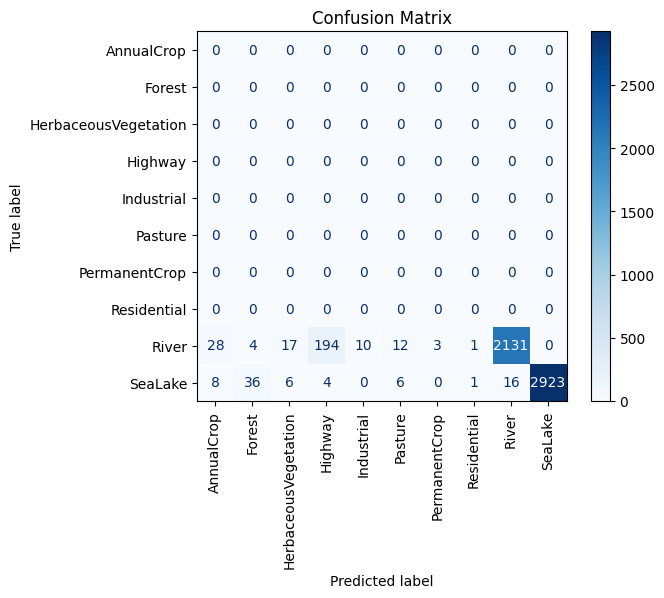

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

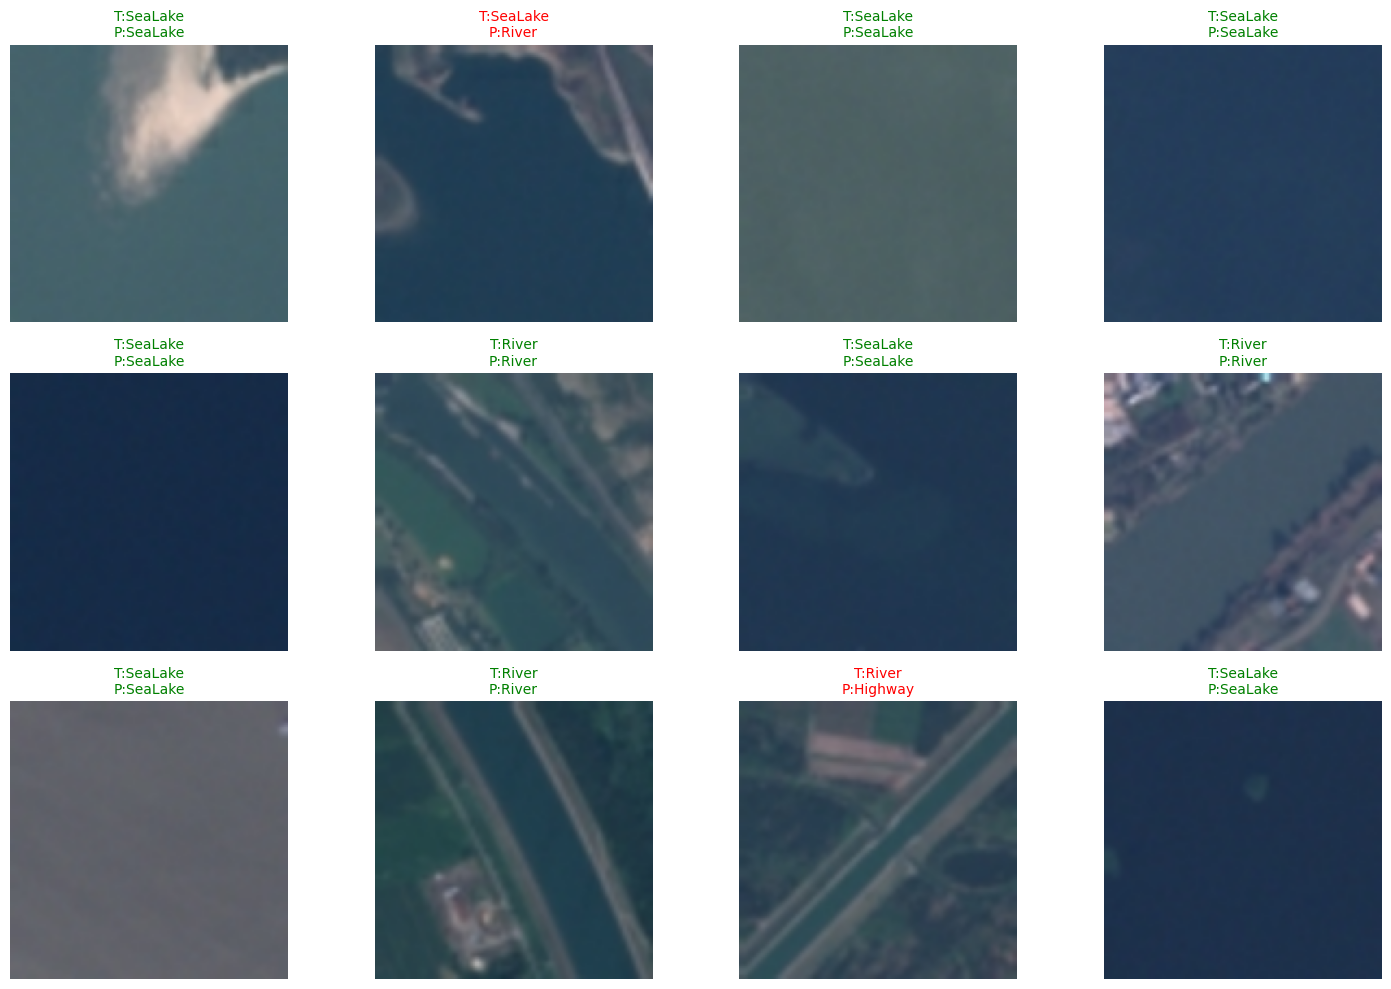

In [ ]:
def show_sample_predictions(dataset, y_true, y_pred, n_samples=12):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(y_true)), n_samples)

    dataset_list = list(dataset)
    for i, idx in enumerate(indices):
        batch_idx = idx // BATCH_SIZE
        img_idx = idx % BATCH_SIZE
        batch_images = dataset_list[batch_idx][0].numpy()
        img = batch_images[img_idx]
        plt.subplot(3, 4, i+1)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        true_class = class_names[y_true[idx]]
        pred_class = class_names[y_pred[idx]]
        plt.title(f"T:{true_class}\nP:{pred_class}", fontsize=10,
                  color='green' if true_class == pred_class else 'red')
    plt.tight_layout()
    plt.show()

show_sample_predictions(val_ds, y_true, y_pred)

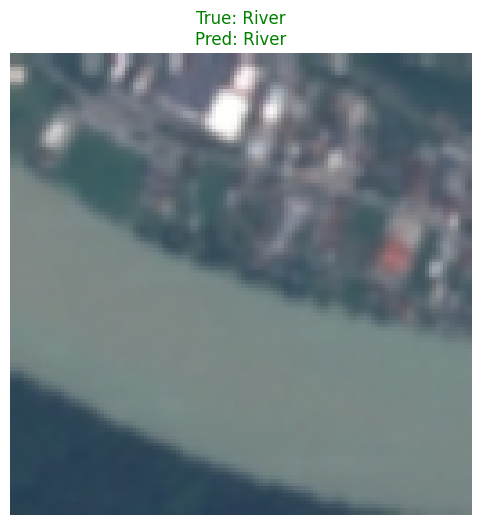

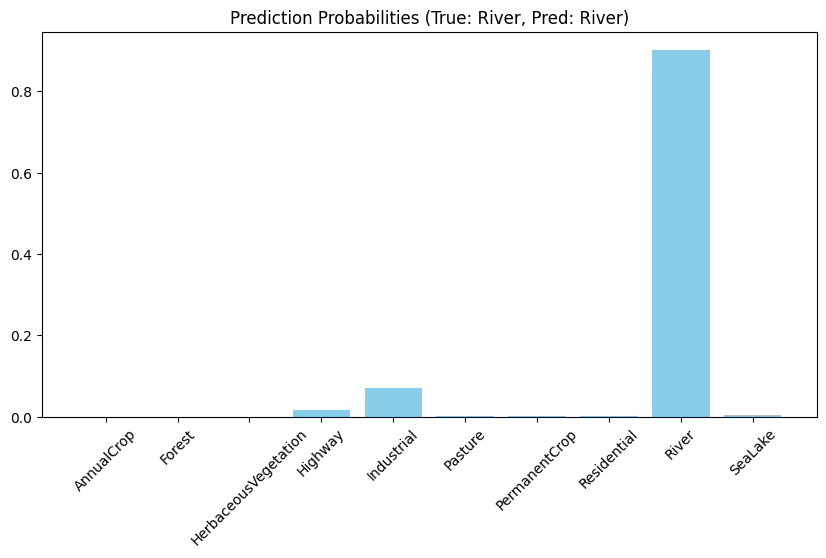

In [ ]:

# Show one random image with its prediction probabilities

random_idx = random.randint(0, len(y_true) - 1)

# الحصول على الصورة من validation dataset
batch_idx = random_idx // BATCH_SIZE
img_idx = random_idx % BATCH_SIZE
batch_images = list(val_ds)[batch_idx][0].numpy()
img = batch_images[img_idx]

# عرض الصورة
plt.figure(figsize=(6,6))
plt.imshow(img.astype('uint8'))
plt.axis('off')
true_class = class_names[y_true[random_idx]]
pred_class = class_names[y_pred[random_idx]]
plt.title(f"True: {true_class}\nPred: {pred_class}",
          color='green' if true_class==pred_class else 'red')
plt.show()

# عرض الاحتمالات لكل الفئات
probs = pred_probs[random_idx]
plt.figure(figsize=(10,5))
plt.bar(class_names, probs, color='skyblue')
plt.xticks(rotation=45)
plt.title(f"Prediction Probabilities (True: {true_class}, Pred: {pred_class})")
plt.show()

# Save Prediction Results

results_df = pd.DataFrame({
    "true": y_true,
    "pred": y_pred
})
results_df["true_name"] = results_df["true"].apply(lambda i: class_names[i])
results_df["pred_name"] = results_df["pred"].apply(lambda i: class_names[i])
results_df.to_csv("/content/prediction_results.csv", index=False)